# Load Dependencies

In [ ]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from script_baseline.Baseline_MG import Get_Baseline_MG_feat_pack
from script_baseline.MIGNN import MIGNN1,Graph_DataLoader
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

# Load Data

In [ ]:
data_file = '../data1/data1.csv'
mol_dir = '../Data/data1/xtb_sdf/'

In [ ]:
tmp_df = pd.read_csv(data_file)
lig_smiles = tmp_df['Ligand'].to_list()
add_smiles = tmp_df['Additive'].to_list()
base_smiles = tmp_df['Base'].to_list()
ar_ha_smiles = tmp_df['Aryl halide'].to_list()
labels = np.array(tmp_df['Output'].to_list())
label_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

lig_smi_set = list(set(lig_smiles))
add_smi_set = list(set(add_smiles))
base_smi_set = list(set(base_smiles))
ar_ha_smi_set = list(set(ar_ha_smiles))

In [ ]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
lig_files = sorted(glob.glob(mol_dir+'lig_*.sdf'),key=sort_func)
add_files = sorted(glob.glob(mol_dir+'add_*.sdf'),key=sort_func)
base_files = sorted(glob.glob(mol_dir+'base_*.sdf'),key=sort_func)
ar_ha_files = sorted(glob.glob(mol_dir+'ar_ha_*.sdf'),key=sort_func)

with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [ ]:
lig_feat,lig_feat_name_dict=Get_Baseline_MG_feat_pack(lig_files)

In [ ]:
ar_ha_feat,ar_ha_feat_name_dict=Get_Baseline_MG_feat_pack(ar_ha_files)

In [ ]:
base_feat,base_feat_name_dict=Get_Baseline_MG_feat_pack(base_files)

In [ ]:
add_feat,add_feat_name_dict=Get_Baseline_MG_feat_pack(add_files)

In [ ]:
total_lig_feat = np.array([lig_feat[lig_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in lig_smiles])
total_add_feat = np.array([add_feat[add_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in add_smiles])
total_base_feat = np.array([base_feat[base_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in base_smiles])
total_ar_ha_feat = np.array([ar_ha_feat[ar_ha_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in ar_ha_smiles])
react_feat = np.concatenate([total_lig_feat,total_add_feat,total_base_feat,total_ar_ha_feat],axis=1)
labels_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

# Train Model

In [ ]:
batch_size = 32
np.random.seed(2021)
shuffle = np.array(list(range(len(react_feat))))
np.random.shuffle(shuffle)
train_index = shuffle[:int(0.7*len(react_feat))]
val_index = shuffle[int(0.7*len(react_feat)):]
feat_train,y_train = react_feat[train_index],label_std[train_index]
feat_val,y_val = react_feat[val_index],label_std[val_index]

train_gen = Graph_DataLoader(feat_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(feat_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(feat_val,y_val,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()

In [ ]:
model_opt = MIGNN1(depth=2,hidden_size=16,attention_depth=1,attention_depth_inter=1,end_attention=1,fc_size=64)

model_opt.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model_opt)
EPOCHS = 50
for epoch in range(EPOCHS):
    hist = model_opt.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./dataset/run_data/data1_Baseline_MG_MIGNN.ckpt')
    print("model saved to %s" % path)  

In [ ]:
opt = tf.keras.optimizers.Adam()
new_model = MIGNN1(depth=2,hidden_size=16,attention_depth=1,attention_depth_inter=1,end_attention=1,fc_size=64)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(valid_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./dataset/run_data/data1_Baseline_MG_MIGNN.ckpt-50')
y_test_pre=new_model.predict(valid_gen_predict)
y_val=label_std[val_index]
y_val = y_val*(np.max(labels)-np.min(labels))+np.min(labels)
y_pred = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)

# Results

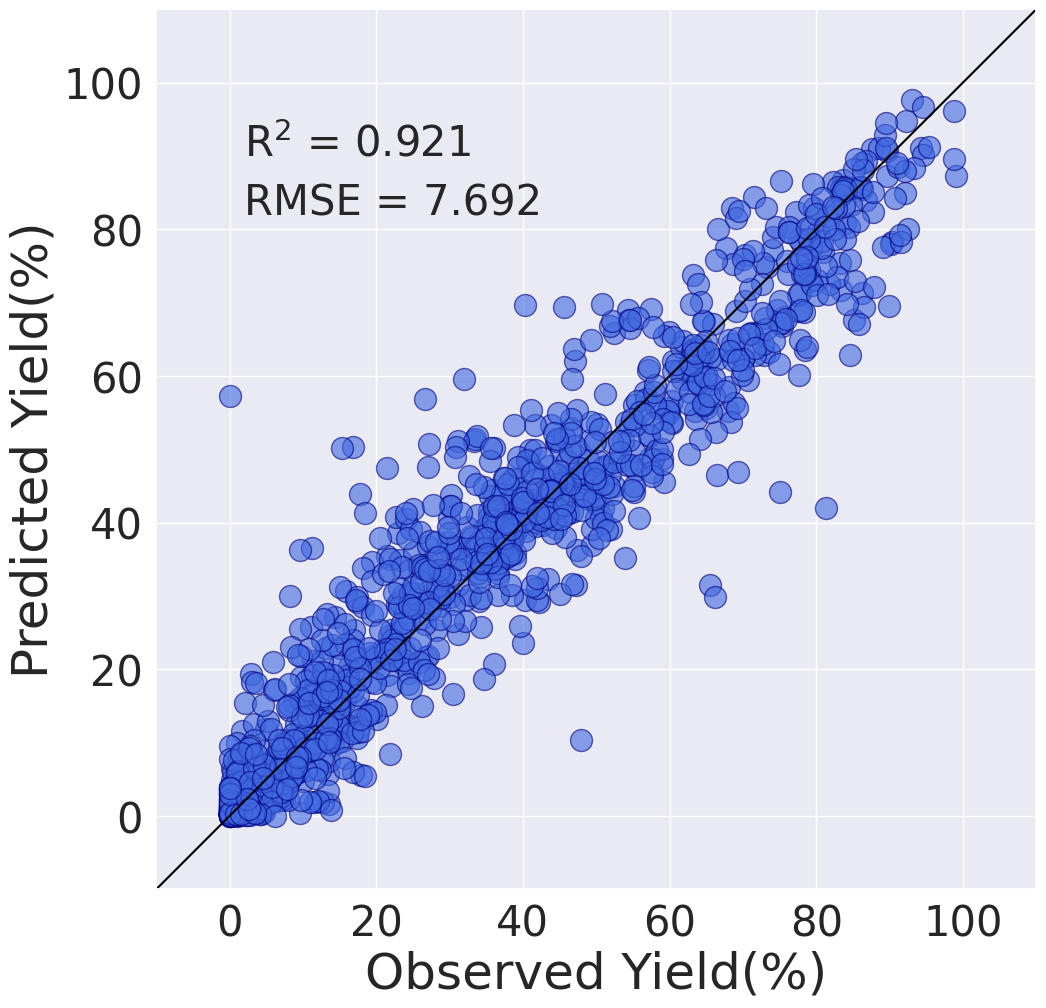

In [3]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)


plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [4]:
np.save('../result/data1_Baseline_MG_MIGNN_y_val.npy',y_val)
np.save('../result/data1_Baseline_MG_MIGNN_y_pred.npy',y_pred)